In [36]:
import requests
import urllib
from pathlib import Path
from tqdm.notebook import tqdm
import tarfile
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch_geometric
from torch_geometric.data import Data
from collections import defaultdict
import numpy as np
%matplotlib inline

In [2]:
data_md_url = "https://github.com/Open-Catalyst-Project/ocp/blob/main/DATASET_PER_ADSORBATE.md?raw=True"
data_mapping_url = "https://dl.fbaipublicfiles.com/opencatalystproject/data/oc20_data_mapping.pkl"
oc20_ref_url = "https://dl.fbaipublicfiles.com/opencatalystproject/data/oc22/oc20_ref.pkl"
md = requests.get(data_md_url).text

In [3]:
adsorbate = "*OH2"
base_path = Path("/network/scratch/s/schmidtv/ocp/datasets/ocp/per_ads")
tarred_path = base_path / "tars"
untarred_paths = base_path / "untarred"
data_mapping_path = base_path / "oc20_data_mapping.pkl"
oc20_ref_path = base_path / "oc20_ref.pkl"

In [4]:
def download_tar(target_path, ads):
    if not target_path.exists():
        print("Downloading...", flush=True, end="")
        response = requests.get(ads["Downloadable path"], stream=True)
        if response.status_code == 200:
            with open(target_path, "wb") as f:
                f.write(response.raw.read())
        print("Done!")
    else:
        print("Using existing tar file.")


def download_pkl(target_path, url):
    if not target_path.exists():
        print("Downloading...", flush=True, end="")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(target_path, "wb") as f:
                f.write(response.raw.read())
        print("Done!")
    else:
        print("Using existing pkl file.")


def untar(fp):
    print("Untarring...", end="", flush=True)
    tar = tarfile.open(fp)
    ads_dir.mkdir(parents=True)
    tar.extractall(path=ads_dir.parent)
    tar.close()
    print("Done!")


def pyg2_data_transform(data: Data):
    """
    if we're on the new pyg (2.0 or later) and if the Data stored is in older format
    we need to convert the data to the new format
    """
    if torch_geometric.__version__ >= "2.0" and "_store" not in data.__dict__:
        return Data(**{k: v for k, v in data.__dict__.items() if v is not None})

    return data

In [5]:
adsorbates = None
for l in md.splitlines():
    if l.startswith("|Adsorbate"):
        cols = [c.strip() for c in l.split("|") if c]
        adsorbates = {c: [] for c in cols}
    if l.startswith("|") and "https" in l:
        vals = [v.strip() for v in l.split("|") if v]
        assert len(vals) == len(cols)
        for v, c in zip(vals, cols):
            adsorbates[c].append(v)
ads = {}
for i in range(len(list(adsorbates.values())[0])):
    a = {col: adsorbates[col][i] for col in cols}
    ads[int(Path(a["Downloadable path"]).stem)] = a
adsorbates = ads

In [6]:
if adsorbate is not None:
    known = [(k, a["Adsorbate symbol"]) for k, a in adsorbates.items()]
    ads_idx = -1
    for k, ads in known:
        if ads == adsorbate:
            ads_idx = k
    assert ads_idx >= 0, f"Adsorbate {adsorbate} does not exist in table: {[p[1] for p in known]}"
    ads = adsorbates[ads_idx]
    print("\n".join(f"{k:20}: {v}" for k, v in ads.items()))

Adsorbate symbol    : *OH2
Downloadable path   : https://dl.fbaipublicfiles.com/opencatalystproject/data/per_adsorbate_is2res/3.tar
size                : 1.8G
MD5 checksum        : b12b706854f5d899e02a9ae6578b5d45


In [7]:
if adsorbate is not None:
    tar_name = Path(ads["Downloadable path"]).name
    ads_id = int(Path(ads["Downloadable path"]).stem)
    ads_dir = untarred_paths / str(ads_id)
    tar_file = tarred_path / tar_name
    traj_dir = ads_dir / str(ads_id)

In [8]:
if not data_mapping_path.exists():
    download_pkl(data_mapping_path, data_mapping_url)
if not oc20_ref_path.exists():
    download_pkl(oc20_ref_path, oc20_ref_url)

if adsorbate is not None and not ads_dir.exists():
    download_tar(tar_file, ads)
    assert tar_file.exists()
    untar(tar_file)
    assert ads_dir.exists()
print("Using data in", str(ads_dir))

Using data in /network/scratch/s/schmidtv/ocp/datasets/ocp/per_ads/untarred/3


In [9]:
with oc20_ref_path.open("rb") as f:
    oc20_ref = pickle.loads(f.read())

In [10]:
with data_mapping_path.open("rb") as f:
    data_mapping = pickle.loads(f.read())

In [11]:
if adsorbate is not None:
    ads_files = list(traj_dir.glob("*.xz"))
    ads_data_mapping = {(k := p.stem.split(".")[0]): data_mapping[k] for p in ads_files}
    print(f"Using {len(ads_data_mapping)} / {len(data_mapping)} adsorbates")
    print("Example:")
    print(list(ads_data_mapping.values())[0])

Using 8036 / 1281041 adsorbates
Example:
{'bulk_id': 2121, 'ads_id': 3, 'bulk_mpid': 'mp-10014', 'bulk_symbols': 'S2Ta', 'ads_symbols': '*OH2', 'miller_index': (1, 0, 1), 'shift': 0.5, 'top': True, 'adsorption_site': ((3.99, 1.13, 16.66),), 'class': 2, 'anomaly': 1}


In [12]:
import json
met = json.loads((base_path / "is2re-all-train.json").read_text())
print(met.keys())

dict_keys(['bulk_id', 'ads_id', 'bulk_mpid', 'bulk_symbols', 'ads_symbols', 'miller_index', 'shift', 'top', 'adsorption_site', 'class', 'anomaly', 'source', 'ds_idx'])


In [13]:
ads_counter = Counter(met["ads_symbols"])

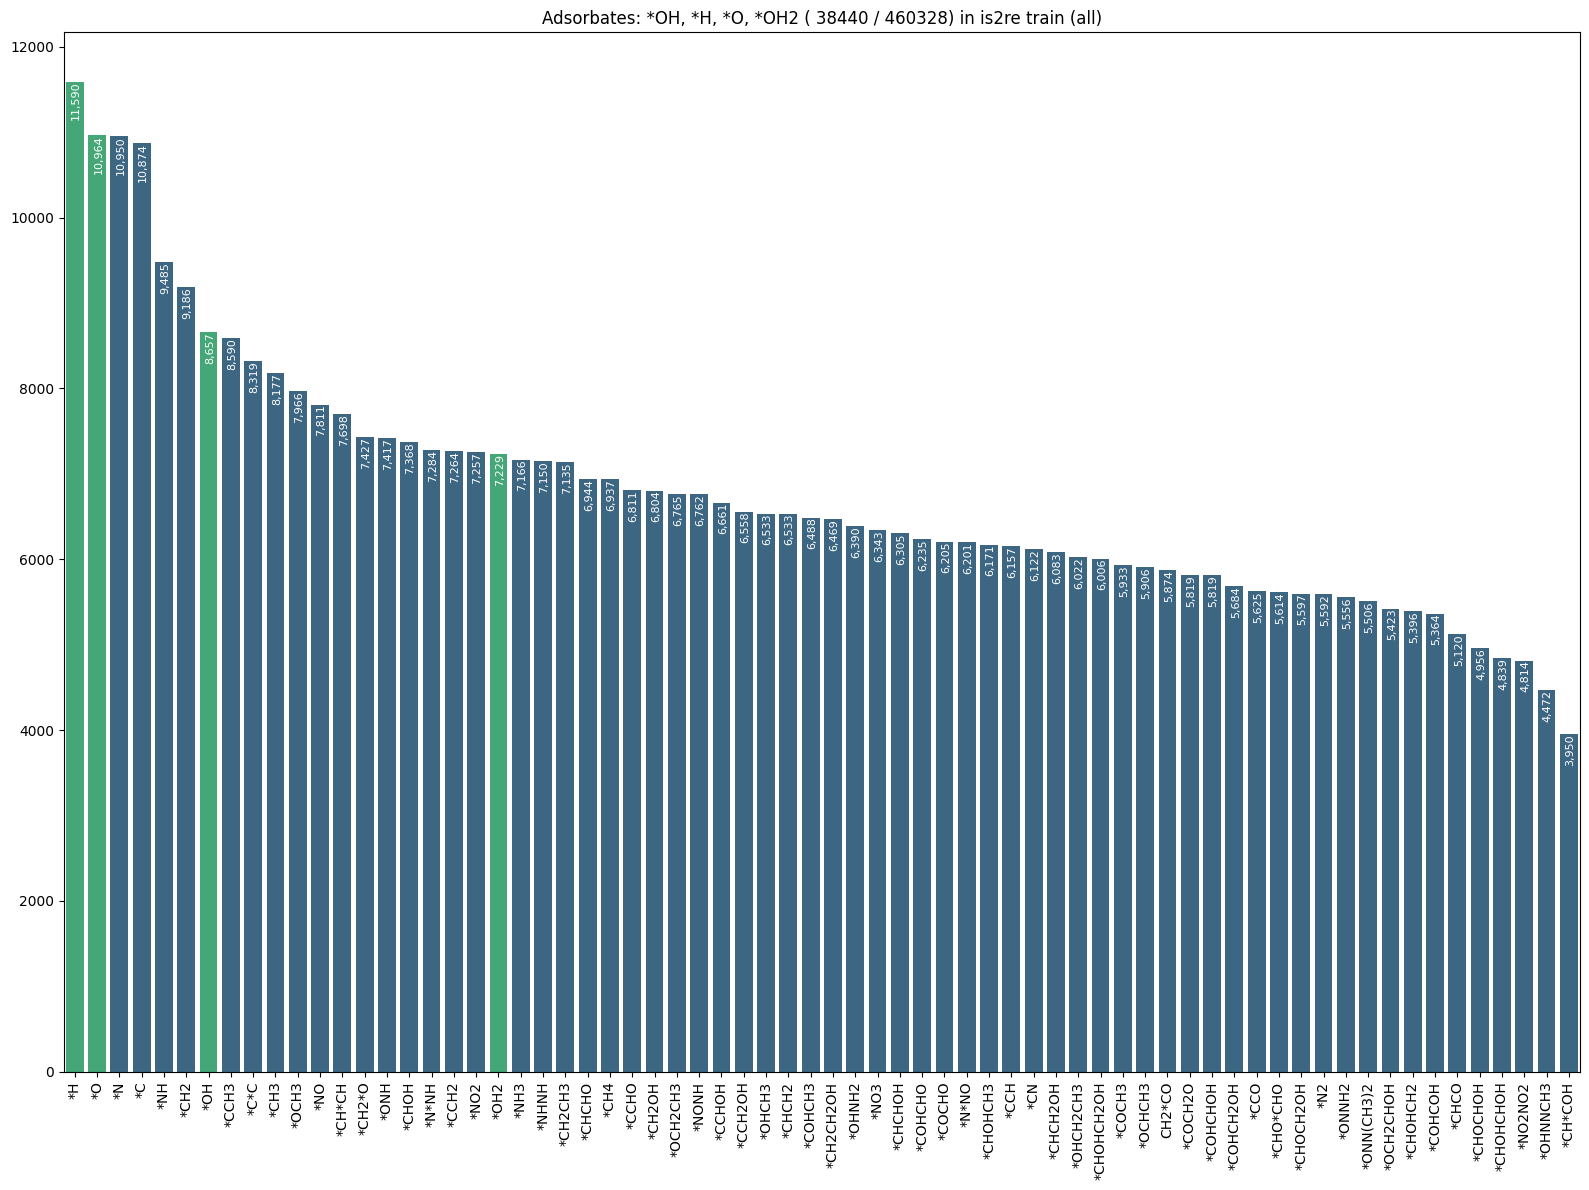

In [45]:
ads = {"*O", "*OH", "*OH2", "*H"}

si = np.argsort(list(ads_counter.values()))[::-1]
x = np.array(list(ads_counter.keys()))[si]
y = np.array(list(ads_counter.values()))[si]

plt.figure(figsize=(16, 12))
cmap = sns.color_palette("viridis", 5)
ax = sns.barplot(
    x=x,
    y=y,
    palette=[cmap[3] if k in ads else cmap[1] for k in x],
    hue=x,
    legend=False,
)
plt.xticks(range(len(x)), x, rotation=90)
for p in ax.patches:
    ax.annotate(
        f"\n{int(p.get_height()):,}",
        (p.get_x() + 0.2, p.get_height()),
        ha="center",
        va="top",
        color="white",
        size=8,
        rotation=90,
    )
if ads:
    plt.title(
        f"Adsorbates: {', '.join(ads)} ( {sum(ads_counter[a] for a in ads)} / {sum(ads_counter.values())})" + " in is2re train (all)"
    )
plt.tight_layout()
plt.show()

In [31]:
i = 12
print(f"{i:,}")

12
